> To do 16/12
> - Packager la partie modeling (nom des dossiers, paramètres d'un modèle à tester, callbacks etc.) 
> - Finaliser la partie model analysis (charger la donnée, learning curves, Matrice de confusion, 4 exemples de X/true/pred, Learning curves, Plot des images qu'il n'arrive pas à gérer ? Et celles qu'il arrive vraiment bien à gérer)
> - Terminer la partie data exploration pour commencer à critiquer le data set et à le catégoriser

# Notebook batch-1831-land-cover-mapping

## ⤵️ Imports

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import shutil
import os
import rasterio


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from glob import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from collections import Counter

### Approche globale 

- Consolider l'ensemble des bases de données pour le projet & répartir les images dans des dossiers train & val
- Identifier, construire un modèle et l'entrainer le modèle en local puis avec TensorFlow DataSet à partir des buckets
- Finetuner le modèle
- Appliquer à google map (incl. API)
- Construire l'interface
- Investiguer les applications business/concrètes possibles

## 🧑🏼‍🍳 Data preparation

### 🎞️ Uploader les images manquantes de XBD

In [ ]:
########### IL VA FALLOIR UPLOADER LES ELEMENTS MANQUANTS ################

# Code qui regarde un csv, cherche le bon fichier dans la BDD XBD, le transforme en numpy array (code Chat utile)
# et le met dans le bon dossier avec le bon nom via la table de correspondance

In [ ]:
def xbd_paths(path):
    #On charge le fichier de correspondance pour le manipuler et construire les chemins sources & destination
    df = pd.read_csv(path, header = None, names = ["source", "destination"])
    df['source'] = df['source'].str.replace(".png",  ".tif")

    #on construit les chemins sources où chercher les images
    sources = list(df["source"])
    sources = ["raw_data/XBD/images/" + source for source in sources]

    #on construit les chemins de destinations où iront les images
    destinations = list(df["destination"])
    destination_paths = []
    dossiers = []
    for destination in destinations:
        dossier = "_".join(destination.split("_")[:-1])
        dossiers.append(dossier) # Certains noms de ville sont composés, il faut tout prendre sauf ce qui vient après le dernier _
        destination_paths.append("raw_data/" + dossier + "/images/" + destination)
    return sources, destination_paths, dossiers

In [4]:
### ✅✅✅✅✅ On construit les variables de paths pour copier les fichiers
sources, destinations, dossiers = xbd_paths("raw_data/xbd_files.csv")

In [ ]:
### ✅✅✅✅✅ On prend chaque fichier et on le copie dans les bons dossiers

for source, destination in zip(sources, destinations):
    shutil.copy(source, destination)

## 🧹 Data cleaning & pre-processing

### 🛤️ Initialiser le listing des chemins vers les images (avant split du train pour créer un set de test)

In [15]:
#✅✅✅✅✅ Création d'un listes avec les noms des fichiers à prendre

#On construit une fonction qui va retourner le chemin vers 1)
#les images du X 2) les images du y - en fonction du paramètre donnee qui est "train", "test", "val"
def read_txt(donnee):
    with open(f"data/raw_data/{donnee}.txt", 'r') as file:
        lines = file.readlines()
        X = []
        y = []
        regions = []
        for line in lines:
            region = '_'.join(line.split("_")[0:-1])
            title = line.replace('\n', '')
            X.append("data/raw_data/"+ region + "/images/" + title)
            y.append("data/raw_data/"+ region + "/labels/" + title)
            regions.append(region)
        return X, y, regions

In [16]:
# ✅✅✅✅✅ On crée les listes pour les différents train et test
X_train_set, y_train_set, regions_train = read_txt("train")
X_val_set, y_val_set, regions_test = read_txt("val")

### 🏋🏻‍♂️ Prendre ~8% de chaque région en train pour le test set 

In [17]:
## Regions uniques & nb_correspondant
regions, nb_region =  np.unique(regions_train, return_counts=True)
## On itère sur chaque région unique
X_test_set = []
y_test_set = []
X_train_set_truncated = X_train_set
y_train_set_truncated = y_train_set

for region, nb in zip(regions, nb_region):
    #On va récupérer les images à prendre des villes - S'il a moins de
    #4 images on prend rien, moins de 20 images on prend 1 et le reste on prend 8%
    if nb < 4:
        pass
    elif nb < 20:
        nb_max =  1
    else:
        nb_max = round(nb*0.08)
    # On initialise le nombre de path ajoutés pour ne pas dépasser le nb_max
    nb_ajoutes = 0
    #On itère sur chaque path du train set
    for path in X_train_set:
        #S'il s'agit de la région alors on enleve les nb_max premiers paths
        if path.split("/")[2] == region and nb_ajoutes < nb_max:
            #On ajoute les X au test et on les supprime du train
            X_test_set.append(path)
            index_X = X_train_set.index(path)
            X_train_set_truncated.remove(path)

            #On ajoute les y au test et on les supprime du train
            y_test_set.append(y_train_set[index_X])
            y_train_set_truncated.remove(y_train_set[index_X])
            
            nb_ajoutes += 1 
        #S'il ne s'agit pas de la région qu'on est en train de chercher alors on ne fait rien
        else:
            pass

In [170]:
#copier les fichiers pour créer la processed_data
X_train_set_final = []
y_train_set_final = []
train_files = []

X_val_set_final = []
y_val_set_final = []
val_files = []

X_test_set_final = []
y_test_set_final = []
test_files = []


for X, y in zip(X_train_set_truncated, y_train_set_truncated):
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_train_set_final.append(X)
        y_train_set_final.append(y)
        train_files.append(X.split("/")[-1])

for X , y  in zip(X_test_set, y_test_set):
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_test_set_final.append(X)
        y_test_set_final.append(y)
        test_files.append(X.split("/")[-1])


for X, y  in zip(X_val_set, y_val_set):
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_val_set_final.append(X)
        y_val_set_final.append(y)
        val_files.append(X.split("/")[-1])

### 🗂️ Créer et peupler les dossiers train/val/test

In [171]:
# ✅✅✅✅✅ On construit une fonction qui va aller chercher les images dont le chemin est
#indiqué dans le set et les sauvegarder dans un dossier train ou val (en fonction du X et du y)
i = 0
# on copie les fichiers pour le train
for X_train, y_train in zip(X_train_set_final, y_train_set_final):
    dst_X_train = "data/clean_data/train/images/"
    os.makedirs(os.path.dirname(dst_X_train), exist_ok=True)
    shutil.copy(X_train, dst_X_train + X_train.split("/")[-1])

    dst_y_train = "data/clean_data/train/labels/"
    os.makedirs(os.path.dirname(dst_y_train), exist_ok=True)
    shutil.copy(y_train, dst_y_train + y_train.split("/")[-1])


#on copie les fichiers sur le val

for  X_val, y_val in zip( X_val_set_final, y_val_set_final):

    dst_X_val = "data/clean_data/val/images/"
    os.makedirs(os.path.dirname(dst_X_val), exist_ok=True)
    shutil.copy(X_val, dst_X_val + X_val.split("/")[-1])

    dst_y_val = "data/clean_data/val/labels/"
    os.makedirs(os.path.dirname(dst_y_val), exist_ok=True)
    shutil.copy(y_val, dst_y_val + y_val.split("/")[-1])


for  X_test, y_test in zip( X_test_set_final, y_test_set_final):

    dst_X_test = "data/clean_data/test/images/"
    os.makedirs(os.path.dirname(dst_X_test), exist_ok=True)
    shutil.copy(X_test, dst_X_test + X_test.split("/")[-1])

    dst_y_test = "data/clean_data/test/labels/"
    os.makedirs(os.path.dirname(dst_y_test), exist_ok=True)
    shutil.copy(y_test, dst_y_test + y_test.split("/")[-1])

### ✂️ Slicer les images et les sauvegarder

In [175]:
### ✅✅✅✅✅ Fonction pour slicer une image
def slicing(image_array, nb_tuiles):
    tuiles_arrays = []
    for tuiles_verticales in range(nb_tuiles):
        for tuiles_horizontales in range(nb_tuiles):
            tuiles_arrays.append(image_array[tuiles_verticales * 256 : 256 * (tuiles_verticales + 1),\
                                 tuiles_horizontales * 256: 256 * (tuiles_horizontales + 1)])
    return tuiles_arrays

In [180]:
def save_tuile(tuiles_arrays, train_file, data_set, images_or_label ):
    path = "data/processed_data/" + data_set + "/" + images_or_label + "/"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    for tuile_id, tuile_array in enumerate(tuiles_arrays):
        if tuile_array.shape[-1] == 1 :
            tuile_array = np.squeeze(tuile_array)
        tuile_array = tuile_array.astype("uint8")
        image = Image.fromarray(tuile_array)
        image.save(path + "/"  + train_file.split(".")[0] + "_" + str(tuile_id + 1) + ".tif")

In [183]:
def crop_tuile(data_set):
    if data_set == "train":
        files = train_files
    elif data_set == "val":
        files = val_files
    elif data_set == "test":
        files = test_files
    path = "data/clean_data/" + data_set + "/"
    #On ouvre chaque image X puis chaque image y. Commençons par les X
    ## Ouverture des X - théoriquement les images seront de même taille
    for file in files:

        with rasterio.open(path + "images/" + file) as src:
            image_array = src.read()  # (nb_bands, height, width)
            image_array = np.transpose(image_array, (1, 2, 0))

        #ensuite on regarde en combien de tuiles on peut le faire
        nb_tuiles = (image_array.shape[0] // 256) # Sur une longueur ou hauteur on peut fiter nb_tuiles + un reste de pixels qui sera perdu
        tuiles_totales = nb_tuiles **2 # ça nous aidera pour le nommage des tuiles (ex = aachen_1_2 - tuile 2 de la photo aachen_1
        #il faudra donc slicer en nb_tuiles à la verticale et à la horizontale

        #On va slicer le X
        tuiles_arrays = slicing(image_array, nb_tuiles)
        #on va sauvegarder les tuiles dans le fichier processed_data/train/images/X
        save_tuile(tuiles_arrays, file, data_set, "images")

        with rasterio.open(path + "labels/" + file) as src:
            image_array = src.read()  # (nb_bands, height, width)
            image_array = np.transpose(image_array, (1, 2, 0))

        #on slide le y de la même manière que le X avec la même convention de nommage (donc le même nom

        tuiles_arrays = slicing(image_array, nb_tuiles)
        #on va sauvegarder les tuiles dans le fichier processed_data/train/images/X
        save_tuile(tuiles_arrays, file, data_set, "labels")


In [184]:
#On lance le crop sur toutes les données de train et de val
crop_tuile("train")
crop_tuile("val")
crop_tuile("test")

### 📀 Tensorflow DataSet - En local

In [166]:
# Définir le ratio des données à utiliser
dataset_size_ratio = 1  # Par exemple, utiliser 50% des données

In [167]:
# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths


# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")
    

In [168]:
# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)


# Charger les chemins des images pour le jeu de validation
test_input_images_dir = "data/processed_data/test/images"
test_target_images_dir = "data/processed_data/test/labels"
test_input_paths, test_target_paths = get_image_paths(test_input_images_dir, test_target_images_dir)


# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)
test_limit = int(len(test_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

test_input_paths = test_input_paths[:train_limit]
test_target_paths = test_target_paths[:train_limit]

In [169]:
# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(test_input_paths, test_target_paths)
)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")
print(f"Nombre d'images de test - Entrée : {len(test_input_paths)}, Cible : {len(test_target_paths)}")

Nombre d'images d'entraînement - Entrée : 39155, Cible : 39155
Nombre d'images de validation - Entrée : 7051, Cible : 7051
Nombre d'images de test - Entrée : 3151, Cible : 3151


## 🗺️ Data exploration
- Next step : interpretation & criticize data set **répartition par ville - graphs** 

### ÷ Répartition des villes/régions variable
- Entre 3 images (2 train 1 val pour Kinshasa) & 87 pour Zanzibar
- Ratio Train/Val assez stable entre 5 et 8 (sauf pour les 8 régions avec le moins de photos)

In [9]:
### Prenons le txt train et val pour compter la répartition des villes 
def repartition_villes(donnee):
    with open(f"data/raw_data/{donnee}.txt", 'r') as file:
        lines = file.readlines()
        X = []
        for line in lines:
            region = ' '.join(line.split("_")[0:-1])
            region = region.title()
            X.append(region)
        villes = np.array(X)
        villes, nb = np.unique(villes, return_counts = True)
        return villes, nb

villes_train, nb_train = repartition_villes("train")
villes_train, nb_val = repartition_villes("val")

repartition_villes_df = pd.DataFrame({ "Train" : nb_train, "Val" : nb_val}, index=villes_train)
repartition_villes_df["Ratio Val/Train"] = repartition_villes_df['Train'] / repartition_villes_df['Val']
repartition_villes_df.sort_values("Train").head(20)

Train  Val  Ratio Val/Train
Kinshasa                 2    1              2.0
Kampala                  4    1              4.0
Bogota                   4    1              4.0
Port A Piment            6    1              6.0
Podlaskie                6    1              6.0
Pointenoire              6    1              6.0
Warminsko-Mazurskie      7    1              7.0
Rosario                  7    1              7.0
Zachodniopomorskie       7    1              7.0
Niamey                   8    1              8.0
Maputo                  10    2              5.0
Chiangmai               12    2              6.0
Saint Louis Du Sud      12    2              6.0
Soriano                 12    2              6.0
Podkarpackie            13    2              6.5
El Rodeo                13    2              6.5
Kujawsko-Pomorskie      13    2              6.5
Lodzkie                 14    2              7.0
Dowa                    14    2              7.0
Lubuskie                14    2              7.0

### 🌃 Répartition des classes

#### Au global

In [170]:
def compute_class_distribution_from_dataset(dataset, num_classes=9):
    class_counts = Counter()
    total_pixels = 0

    # Parcourir le dataset
    for _, target_batch in dataset:
        # Convertir en numpy array pour le traitement
        target_batch = target_batch.numpy()  # (batch_size, 256, 256, 1)
        target_batch = target_batch.squeeze(axis=-1)  # Supprimer la dimension du canal (256, 256, 1) -> (256, 256)

        # Compter les classes dans le batch
        for target_array in target_batch:
            unique, counts = np.unique(target_array.astype(int), return_counts=True)
            class_counts.update(dict(zip(unique, counts)))

            # Ajouter le nombre total de pixels
            total_pixels += target_array.size

    # Calcul des pourcentages pour chaque classe
    class_distribution = {class_id: (count / total_pixels) * 100 for class_id, count in class_counts.items()}

    # Ajouter les classes manquantes avec 0%
    for class_id in range(num_classes):
        if class_id not in class_distribution:
            class_distribution[class_id] = 0.0

    # Trier par classe
    class_distribution = dict(sorted(class_distribution.items()))

    return class_distribution


# Calculer la répartition pour chaque dataset
train_class_distribution = compute_class_distribution_from_dataset(train_dataset)
val_class_distribution = compute_class_distribution_from_dataset(val_dataset)
test_class_distribution = compute_class_distribution_from_dataset(test_dataset)

train_class_distribution_rounded = {key: round(value, 2) for key, value in train_class_distribution.items()}
val_class_distribution_rounded = {key: round(value, 2) for key, value in val_class_distribution.items()}
test_class_distribution_rounded = {key: round(value, 2) for key, value in test_class_distribution.items()}


# Créer un DataFrame
df_class_distribution = pd.DataFrame({
    "Train Global": train_class_distribution_rounded,
    "Val Global": val_class_distribution_rounded,
    "Test Global": test_class_distribution_rounded
})

# Assurez-vous que les colonnes sont triées par classe
df_class_distribution.index.name = "Classe"

In [171]:
df_class_distribution

Train Global  Val Global  Test Global
Classe                                       
0               0.62        0.74         0.93
1               1.64        1.24         1.05
2              22.84       22.87        22.43
3              15.66       16.38        15.63
4               6.45        6.59         5.95
5              20.03       20.46        19.58
6               3.40        2.89         4.02
7              14.17       13.06        14.76
8              15.18       15.76        15.66

#### 🏘️ Dans chaque région vs le global

**Liste des régions disponibles :**

*Aachen, Abancay, Accra, Adelaide, Al Qurnah, Austin, Baybay, Bielefeld, Bogota, Buenos Aires, Chiangmai, Chicago, Chiclayo, Chincha, Chisinau, Christchurch, Coxsbazar, Daressalaam, Dhaka, Dolnoslaskie, Dortmund,Dowa, Duesseldorf, El Rodeo, Gorakhpur, Houston, Ica,       Jeremie, Joplin, Kagera, Kampala, Khartoum, Kinshasa, Kitsap, Koeln, Kujawsko-Pomorskie, Kyoto, Labuhan, Lambayeque, Leilane Estates, Les Cayes, Lima, Little Rock, Lodzkie, Lohur, Lubuskie, Mahe, Malopolskie, Maputo, Mazowieckie, Melbourne, Mexico City, Monrovia, Muenster, Ngaoundere, Niamey, Oklahoma, Palu, Panama City, Paris, Pedrogao Grande, Pisco, Piura, Podkarpackie, Podlaskie, Pointenoire, Pomorskie,       Port A Piment, Rio, Rosario, Rotterdam, Saint Louis Du Sud, San Tome, Santa Rosa, Santiago,       Sechura, Shanghai, Slaskie, Soriano, Svaneti, Swietokrzyskie, Thousand Oaks, Tokyo, Tonga, Tulsa, Tuscaloosa, Tyrolw, Ulaanbaatar, Vegas, Vienna, Viru, Wallace, Warminsko-Mazurskie, Western, Wielkopolskie, 2achodniopomorskie, Zanzibar*

In [127]:
# On a la variable region qui contient toutes les régions disponibles. 
#Il faut créer une fonction qui permet de voir la répartition des classes sur chaque région pour chaque dataset
def class_repartition_per_region(region, dataset):

    class_counts = Counter()
    total_pixels = 0
    if dataset == "train":
        paths = train_target_paths
    elif dataset == "test":
        paths = test_target_paths
    elif dataset == "val":
        paths = val_target_paths

    for path in paths:
        if "_".join((path.split("/")[4]).split("_")[0:-2]) == region:
            im = Image.open(path)
            image = np.array(im)
            num_classes, nb_count  = np.unique(image, return_counts=True)
            class_counts.update(dict(zip(num_classes, nb_count)))

            # Ajouter le nombre total de pixels
            total_pixels += image.size

    # Calcul des pourcentages pour chaque classe
    class_distribution = {class_id: (nb_count / total_pixels) * 100 for class_id, nb_count in class_counts.items()}

    # Ajouter les classes manquantes avec 0%
    for class_id in range(9):
        if class_id not in class_distribution:
            class_distribution[class_id] = 0.0

    # Trier par classe
    class_distribution = dict(sorted(class_distribution.items()))

    return class_distribution

def repartition_region_all(region):

    train_class = class_repartition_per_region(region, "train")
    val_class = class_repartition_per_region(region, "val")
    test_class = class_repartition_per_region(region, "test")
    
    train_class = {key: round(value, 2) for key, value in train_class.items()}
    val_class = {key: round(value, 2) for key, value in val_class.items()}
    test_class = {key: round(value, 2) for key, value in test_class.items()}
    
    return  pd.concat([pd.DataFrame({"Train" : train_class,
              "Val" : val_class,
              "Test" : test_class}, 
             index = test_class.keys()), df_class_distribution], axis = 1)
    

In [172]:
repartition_region_all("aachen")

Train    Val   Test  Train Global  Val Global  Test Global
0   0.00   0.00   0.00          0.62        0.74         0.93
1   0.03   0.00   0.00          1.64        1.24         1.05
2  23.24  17.52  26.91         22.84       22.87        22.43
3  13.99  18.52  10.11         15.66       16.38        15.63
4   6.34   5.88   5.22          6.45        6.59         5.95
5  16.69   9.39  15.87         20.03       20.46        19.58
6   0.14   0.01   0.01          3.40        2.89         4.02
7  23.24  26.27  30.23         14.17       13.06        14.76
8  16.34  22.42  11.66         15.18       15.76        15.66

## 💻 Modeling

- initiate_model(model_type, callbacks) -- WIP
- **Next steps** : pre-trained model, model analytics , IoU loss, améliorer le visu (lignes droites etc..) + ouverture pendant la prez sur ce qu'il reste à faire (ex labellisation etc.), temps d'entrainement

### 📞 Callbacks

**Content:**
- EarlyStopping (4, restore)
- ModelCheckpoint (only weights & best)

**Params:**
- Test_id
- Data (full/partial)

In [12]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

### 🏛️ Model architectures

- unet (input_shape, num_classes)
- resunet (input_shaep, num_classes)

In [11]:
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model

### 🌏 Model compiling & fitting

### 📈 Model analysing & plotting


- Matrice de confusion
- 4 exemples de X/true/pred
- Learning curves
- Plot des images qu'il n'arrive pas à gérer ? Et celles qu'il arrive vraiment bien à gérer

## 🏉 Models testing

### A.1 Original - 32 batch size = 3 sec + 57%

In [ ]:
#paramètres du test
folder_name = ""

In [17]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [18]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model
model = unet((256, 256, 3),9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data = val_dataset, batch_size = 32, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 11:48:09.548118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      6/Unknown - 16s 3s/step - loss: 2.3090 - accuracy: 0.2282

2024-12-12 11:48:25.471578: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1707719190740100498
2024-12-12 11:48:25.471593: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11288607318187344883
2024-12-12 11:48:25.613498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 18s 3s/step - loss: 2.3090 - accuracy: 0.2282 - val_loss: 2.0039 - val_accuracy: 0.2463


2024-12-12 11:48:26.336017: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8124501954066137179
2024-12-12 11:48:26.336030: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9279868874009222071
2024-12-12 11:48:26.336035: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14037855502445574162
2024-12-12 11:48:26.336039: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10579861509864060216
2024-12-12 11:48:26.336046: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12615357760222789386


Epoch 2/100
6/6 [==============================] - 16s 3s/step - loss: 2.0390 - accuracy: 0.1990 - val_loss: 4.5725 - val_accuracy: 0.1436
Epoch 3/100
6/6 [==============================] - 16s 3s/step - loss: 2.4247 - accuracy: 0.2051 - val_loss: 2.0113 - val_accuracy: 0.2028
Epoch 4/100
6/6 [==============================] - 17s 3s/step - loss: 1.9698 - accuracy: 0.2023 - val_loss: 1.8553 - val_accuracy: 0.2029
Epoch 5/100
6/6 [==============================] - 17s 3s/step - loss: 1.8175 - accuracy: 0.2291 - val_loss: 1.6926 - val_accuracy: 0.3234
Epoch 6/100
6/6 [==============================] - 16s 3s/step - loss: 1.7506 - accuracy: 0.2717 - val_loss: 1.6898 - val_accuracy: 0.3228
Epoch 7/100
6/6 [==============================] - 17s 3s/step - loss: 1.7277 - accuracy: 0.2720 - val_loss: 1.6758 - val_accuracy: 0.3233
Epoch 8/100
6/6 [==============================] - 17s 3s/step - loss: 1.7124 - accuracy: 0.2716 - val_loss: 1.6619 - val_accuracy: 0.3230
Epoch 9/100
6/6 [==========

### A.2 batch size 64 = 5s & 62%

In [53]:
# Paramètres de sauvegarde du modèle 

id = "A.2"
taille_data = "partial"
attribut = "batch_size_64"
dossier = "models/" + id + " - " + attribut + "_" + taille_data

'models/A.2 - batch_size_64_partial'

In [19]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [47]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path =  dossier + '/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model

model = unet((256, 256, 3),9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.load_weights("models/Meilleurs models/Partial Data/A.2 PARTIAL DATA model_epoch_56_val_accuracy_0.62.h5")

1/1 [==============================] - 0s 11ms/step


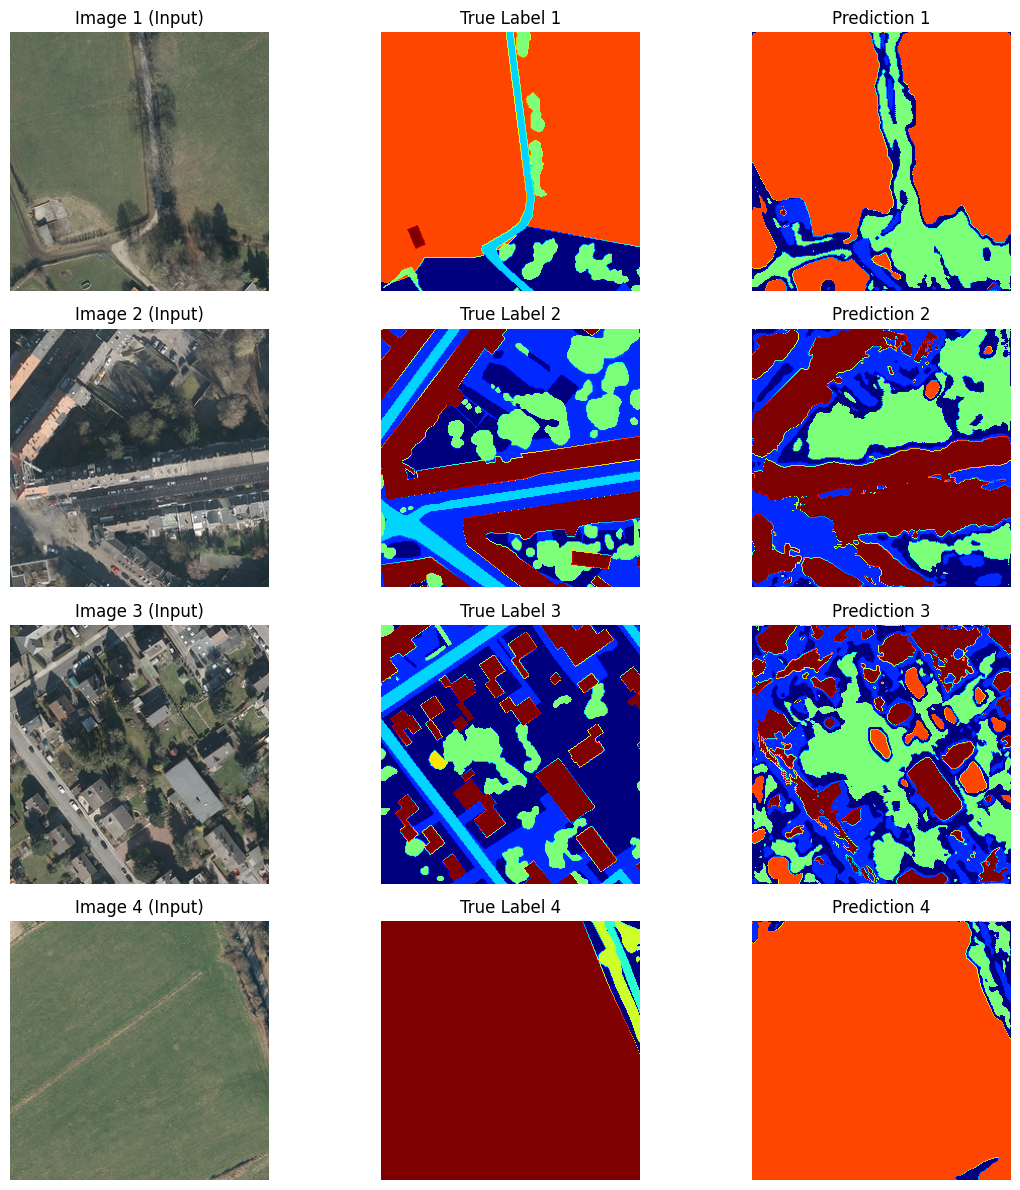

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

### original avec IoU metrics - Ne marche pas 

In [31]:
def iou_metric(y_true, y_pred):
    # Si vous faites de la segmentation binaire, vous pouvez arrondir les prédictions
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

In [27]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [32]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model

model = unet((256, 256, 3),9)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy', iou_metric])
history = model.fit(train_dataset, validation_data = val_dataset, batch_size = 32, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 12:18:56.150986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      6/Unknown - 14s 2s/step - loss: 2.2676 - accuracy: 0.1909 - iou_metric: 0.1070   

2024-12-12 12:19:09.668359: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 566809887459385858
2024-12-12 12:19:09.668375: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8903956609564657560
2024-12-12 12:19:09.668390: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11758384038986204065
2024-12-12 12:19:09.777454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 15s 2s/step - loss: 2.2676 - accuracy: 0.1909 - iou_metric: 0.1070 - val_loss: 1.9210 - val_accuracy: 0.2966 - val_iou_metric: 0.0000e+00
Epoch 2/100


2024-12-12 12:19:10.465868: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5120658449776109610
2024-12-12 12:19:10.465881: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16748144125138967033
2024-12-12 12:19:10.465891: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15846358909402360732
2024-12-12 12:19:10.465896: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4002720322113299463


6/6 [==============================] - 14s 2s/step - loss: 1.8878 - accuracy: 0.2677 - iou_metric: 0.0000e+00 - val_loss: 1.7401 - val_accuracy: 0.2915 - val_iou_metric: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 14s 2s/step - loss: 1.8261 - accuracy: 0.2505 - iou_metric: 0.0431 - val_loss: 1.7011 - val_accuracy: 0.3227 - val_iou_metric: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 14s 2s/step - loss: 1.7375 - accuracy: 0.2717 - iou_metric: 0.0000e+00 - val_loss: 1.6810 - val_accuracy: 0.3226 - val_iou_metric: 7.9520e-07
Epoch 5/100
6/6 [==============================] - 14s 2s/step - loss: 1.7239 - accuracy: 0.2720 - iou_metric: 0.0148 - val_loss: 1.6559 - val_accuracy: 0.3237 - val_iou_metric: 0.0026
Epoch 6/100
6/6 [==============================] - 14s 2s/step - loss: 1.7043 - accuracy: 0.2724 - iou_metric: 0.0027 - val_loss: 1.6582 - val_accuracy: 0.3243 - val_iou_metric: 0.0000e+00
Epoch 7/100
6/6 [==============================] - 14s 2s/step 

1/1 [==============================] - 0s 11ms/step


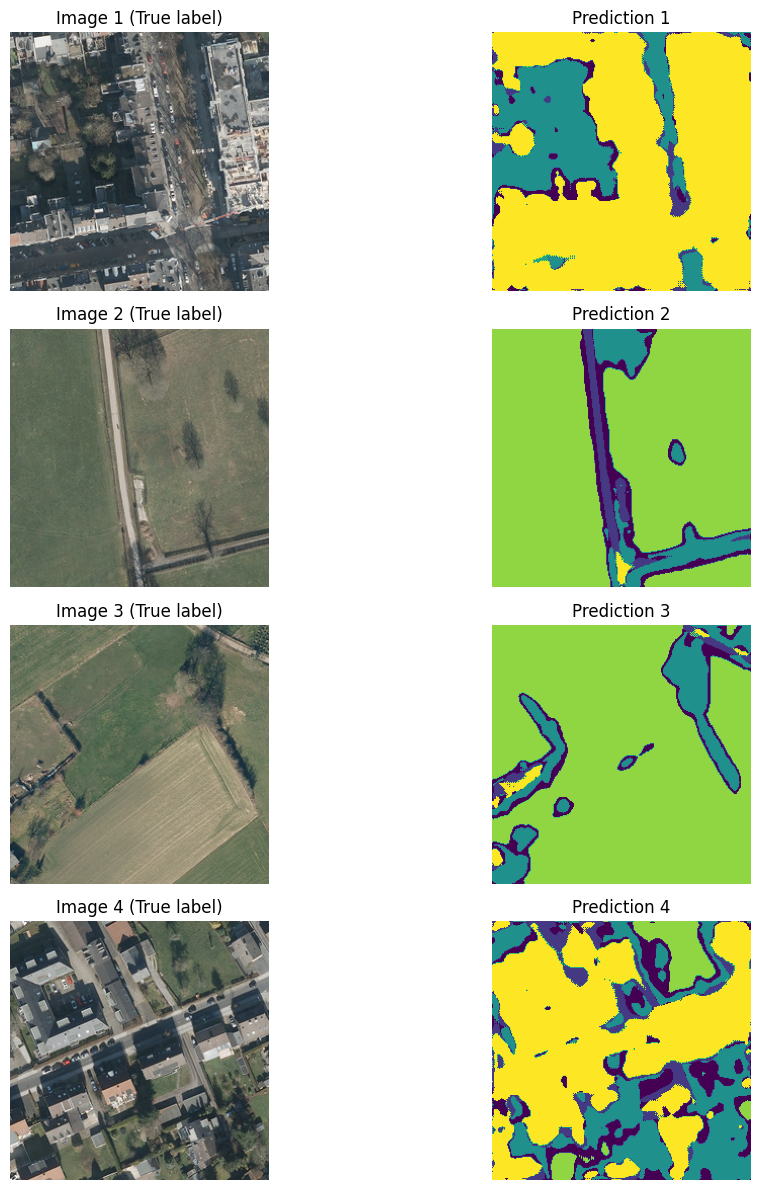

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image originale
            plt.subplot(num_images, 2, 2*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (True label)")
            plt.axis('off')

            # Affichage de la prédiction (affichage de la classe prédite)
            plt.subplot(num_images, 2, 2*i+2)
            plt.imshow(pred_class.squeeze())  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

1/1 [==============================] - 0s 11ms/step


2024-12-12 12:41:24.014261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


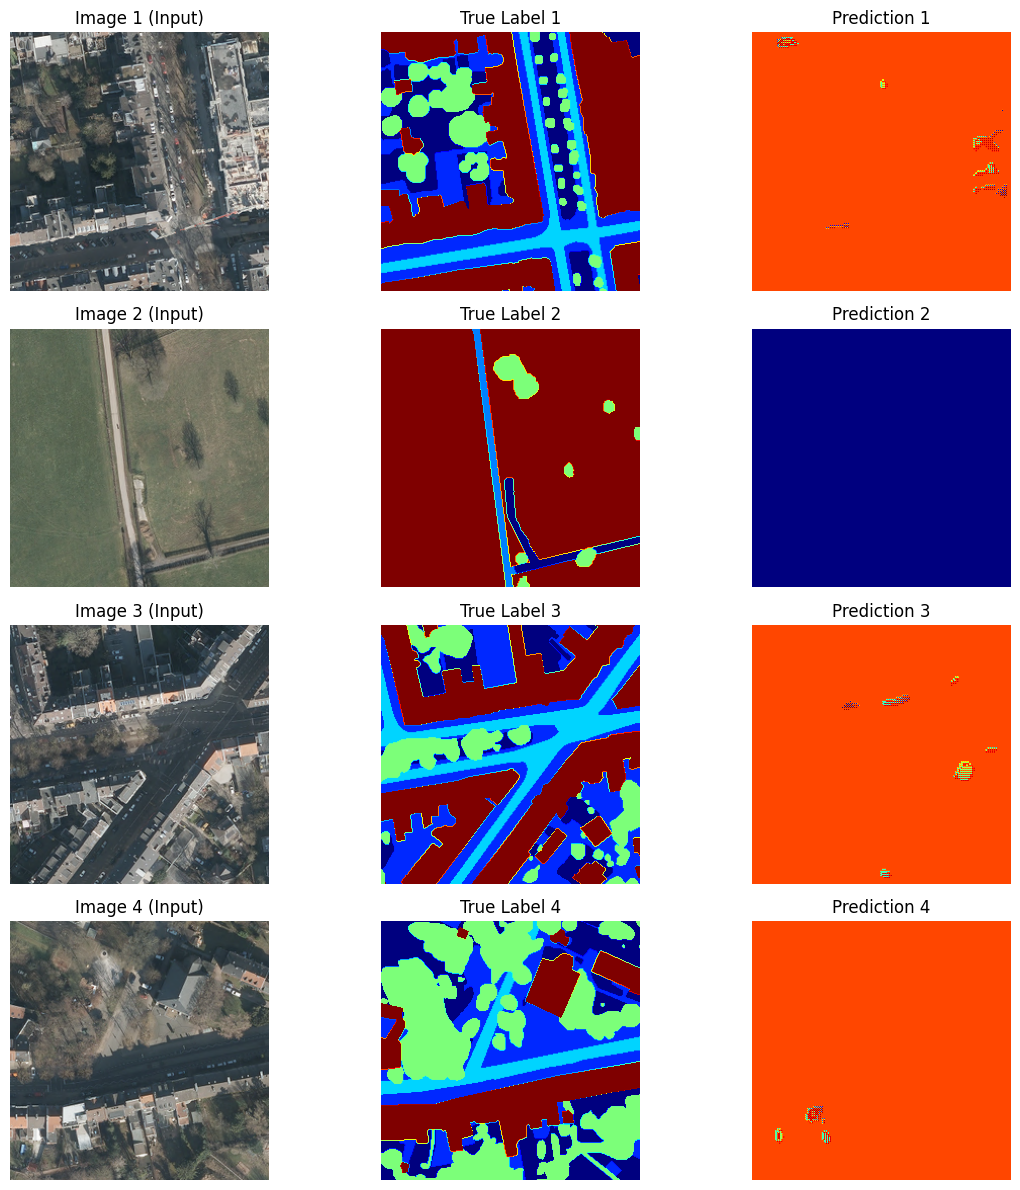

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

### Optimizer adam learning rate 

In [41]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [42]:
## Callbacks
es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path = 'models/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model

model = unet((256, 256, 3),9)
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy', iou_metric])
history = model.fit(train_dataset, validation_data = val_dataset, batch_size = 32, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 12:44:17.779270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      6/Unknown - 14s 2s/step - loss: 3793008.5000 - accuracy: 0.1300 - iou_metric: 3.9924

2024-12-12 12:44:31.050476: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4736452183684247546
2024-12-12 12:44:31.050491: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4235120653256499336
2024-12-12 12:44:31.050495: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11758384038986204065
2024-12-12 12:44:31.050508: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9264436764061744543
2024-12-12 12:44:31.050513: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1929875478821717903
2024-12-12 12:44:31.050518: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8903956609564657560
2024-12-12 12:44:31.163660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114]

6/6 [==============================] - 15s 2s/step - loss: 3793008.5000 - accuracy: 0.1300 - iou_metric: 3.9924 - val_loss: 353951.8750 - val_accuracy: 0.2052 - val_iou_metric: 5.2934
Epoch 2/100
6/6 [==============================] - 15s 2s/step - loss: 530154.5000 - accuracy: 0.1780 - iou_metric: 4.2902 - val_loss: 2.1564 - val_accuracy: 0.0974 - val_iou_metric: 1.2685e-04
Epoch 3/100
6/6 [==============================] - 14s 2s/step - loss: 298.4685 - accuracy: 0.1932 - iou_metric: 0.8003 - val_loss: 4.3615 - val_accuracy: 0.0974 - val_iou_metric: 0.0011
Epoch 4/100
6/6 [==============================] - 16s 3s/step - loss: 1823272.8750 - accuracy: 0.2023 - iou_metric: 1.6298 - val_loss: 1602.2230 - val_accuracy: 0.0984 - val_iou_metric: 0.1279
Epoch 5/100
6/6 [==============================] - 14s 2s/step - loss: 430.0918 - accuracy: 0.1916 - iou_metric: 0.0226 - val_loss: 2.0740 - val_accuracy: 0.0974 - val_iou_metric: 1.0060e-04
Epoch 6/100
6/6 [==============================] -

1/1 [==============================] - 0s 13ms/step


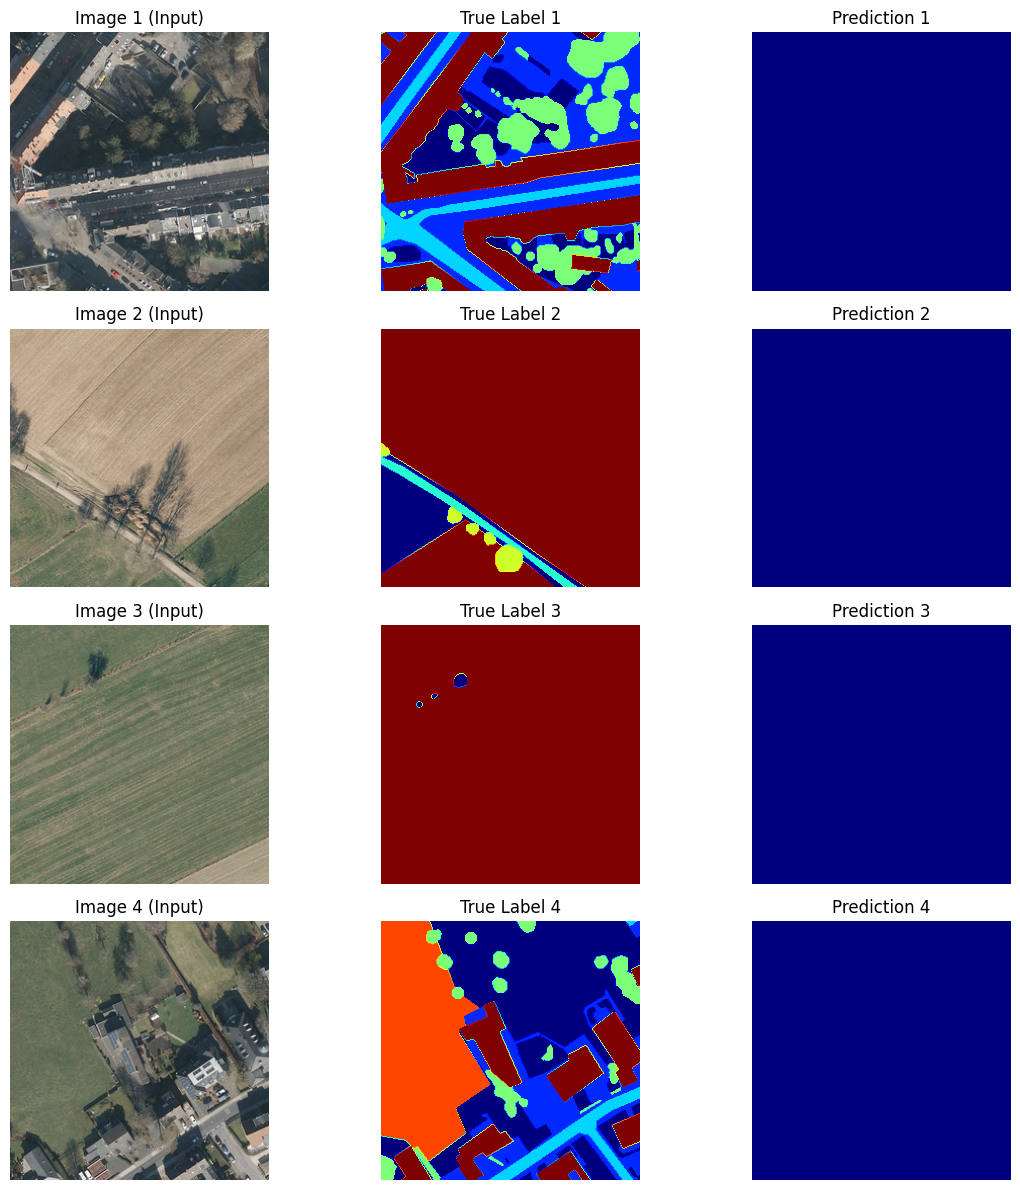

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

### Res-UNET

In [54]:
import numpy as np

# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [58]:
def residual_block(x, filters):
    # Shortcut to match filters if needed
    shortcut = Conv2D(filters, (1, 1), padding='same')(x) if x.shape[-1] != filters else x
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Add()([shortcut, x])  # Combine shortcut and convolutional path
    return x
def resunet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Adjust input channels to match the first residual block
    inputs_adjusted = Conv2D(64, (1, 1), padding='same')(inputs)
    # Encoder Block 1
    conv1 = residual_block(inputs_adjusted, 64)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = residual_block(pool4, 1024)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = residual_block(concat1, 512)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = residual_block(concat2, 256)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = residual_block(concat3, 128)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = residual_block(concat4, 64)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="Res-U-Net")
    return model

model = resunet((256, 256, 3),9)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, validation_data = val_dataset, batch_size = 32, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 15:36:44.303877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      6/Unknown - 18s 3s/step - loss: 1.9826 - accuracy: 0.2415

2024-12-12 15:37:01.755685: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12079045578406857469
2024-12-12 15:37:01.755699: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1426786114789915477
2024-12-12 15:37:01.755704: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2175642257791477599
2024-12-12 15:37:01.889886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-12 15:37:02.745729: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4350007951263873499
2024-12-12 15:37:02.745743: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10844431209334807237
2024-12-12 15:37:02.745748: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous 

6/6 [==============================] - 19s 3s/step - loss: 1.9826 - accuracy: 0.2415 - val_loss: 1.8180 - val_accuracy: 0.3591
Epoch 2/100
6/6 [==============================] - 18s 3s/step - loss: 1.8502 - accuracy: 0.3078 - val_loss: 1.6673 - val_accuracy: 0.3267
Epoch 3/100
6/6 [==============================] - 18s 3s/step - loss: 2.0479 - accuracy: 0.2567 - val_loss: 1.7413 - val_accuracy: 0.3658
Epoch 4/100
6/6 [==============================] - 18s 3s/step - loss: 1.7684 - accuracy: 0.2296 - val_loss: 1.7265 - val_accuracy: 0.2482
Epoch 5/100
6/6 [==============================] - 18s 3s/step - loss: 1.7314 - accuracy: 0.2746 - val_loss: 1.5910 - val_accuracy: 0.3627
Epoch 6/100
6/6 [==============================] - 18s 3s/step - loss: 1.6585 - accuracy: 0.3102 - val_loss: 1.5342 - val_accuracy: 0.3875
Epoch 7/100
6/6 [==============================] - 18s 3s/step - loss: 1.7028 - accuracy: 0.2791 - val_loss: 1.6601 - val_accuracy: 0.3954
Epoch 8/100
6/6 [======================

1/1 [==============================] - 0s 12ms/step


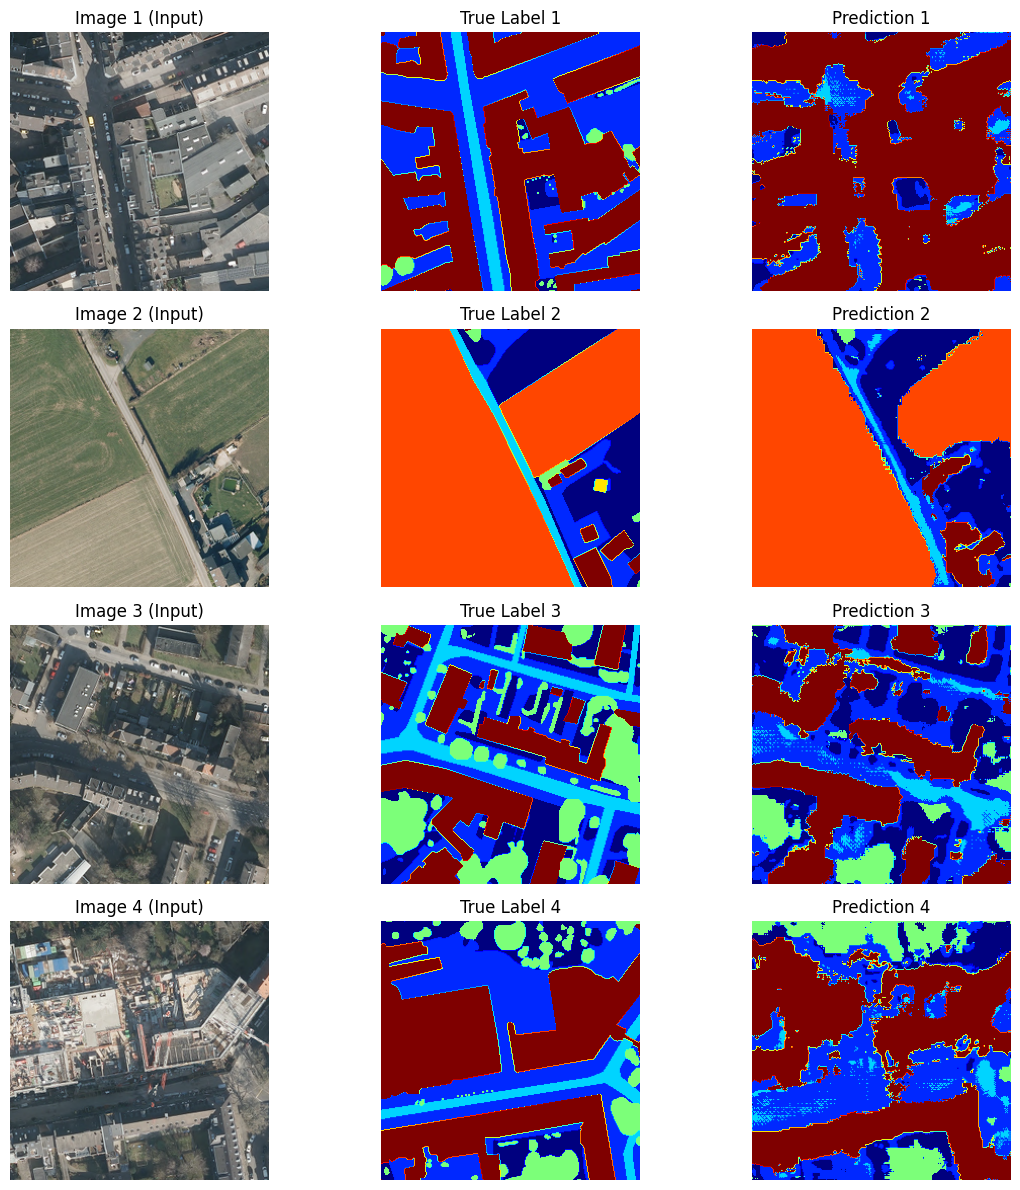

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

### 👑👑👑👑👑👑👑👑👑👑👑 Dice loss + RES Unet 👑👑👑👑👑👑👑👑👑👑👑👑👑👑👑👑 A check si combined loss 

In [130]:
# Paramètres de sauvegarde du modèle 

## Call
id = "C.3"
taille_data = "partial"
attribut = "Batch_64_Dice_loss_RESUNET"
dossier = "models/" + id + " - " + attribut + "_" + taille_data


es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path =  dossier + '/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)


In [149]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice loss for multi-class segmentation.
    :param y_true: Ground truth, one-hot encoded or sparse categorical
    :param y_pred: Predicted logits (after softmax)
    :param smooth: Smoothing factor to avoid division by zero
    :return: Dice loss value
    """
    # Si y_true est en format sparse, on applique one-hot
    num_classes = tf.shape(y_pred)[-1]
    if tf.rank(y_true) == tf.rank(y_pred) - 1:
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0)  # éviter des prédictions égales à 0
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)  # Dice Loss

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return ce_loss + d_loss


In [150]:
def residual_block(x, filters):
    # Shortcut to match filters if needed
    shortcut = Conv2D(filters, (1, 1), padding='same')(x) if x.shape[-1] != filters else x
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Add()([shortcut, x])  # Combine shortcut and convolutional path
    return x
def resunet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Adjust input channels to match the first residual block
    inputs_adjusted = Conv2D(64, (1, 1), padding='same')(inputs)
    # Encoder Block 1
    conv1 = residual_block(inputs_adjusted, 64)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = residual_block(pool4, 1024)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = residual_block(concat1, 512)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = residual_block(concat2, 256)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = residual_block(concat3, 128)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = residual_block(concat4, 64)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="Res-U-Net")
    return model

model = resunet((256, 256, 3),9)

model.load_weights("models/C.2 - Dice_loss_RESUNET_partial/model_epoch_39_val_accuracy_0.70.h5")


1/1 [==============================] - 0s 11ms/step


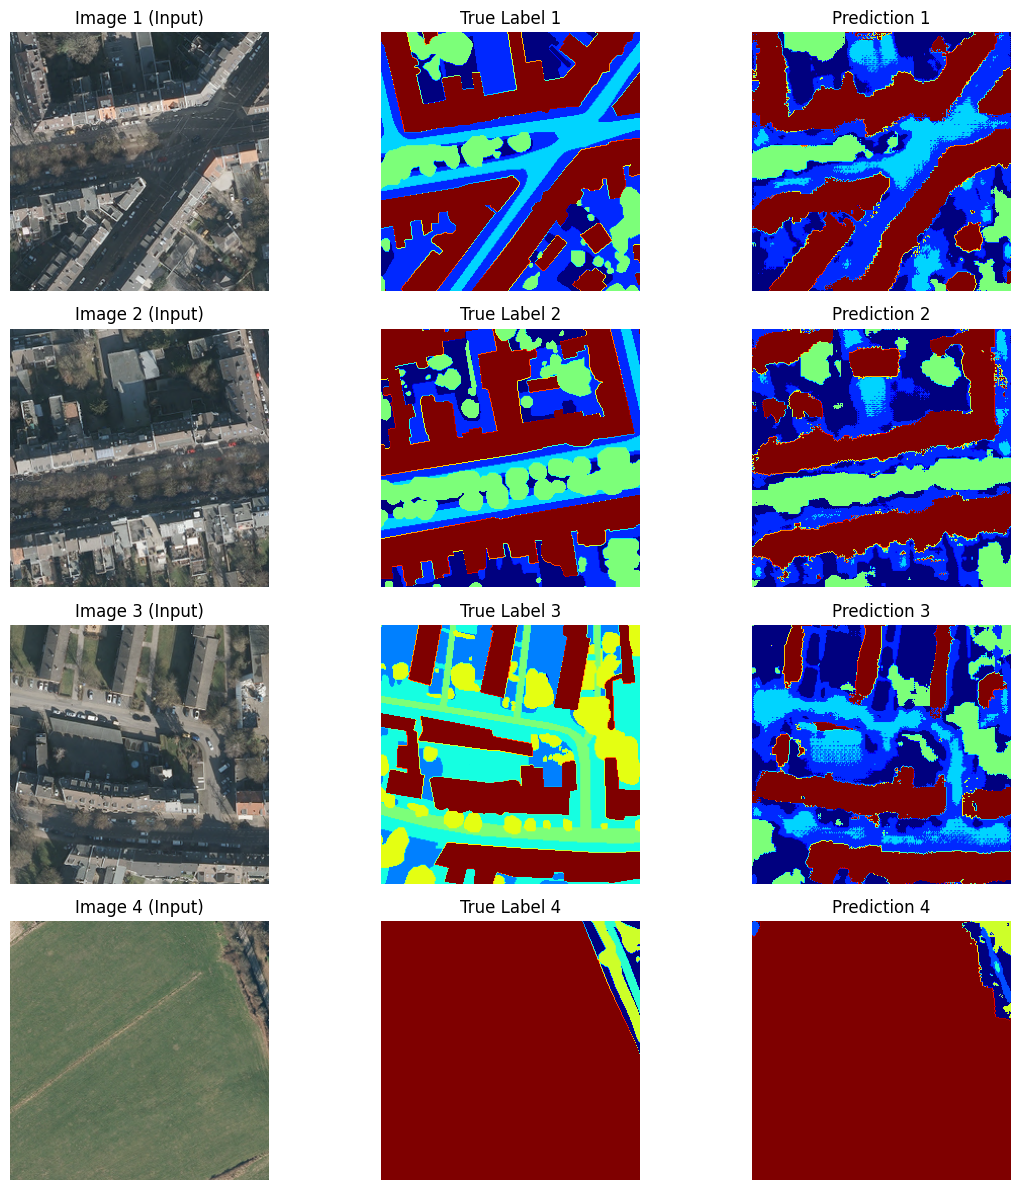

In [173]:
# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

# Étape 1 : Extraire les vraies étiquettes et prédictions
true_labels = []
predictions = []

# Boucle sur le test_dataset (par batch de 32)
for batch_images, batch_labels in test_dataset:  
    # Convertir les labels en numpy array (vraies étiquettes)
    true_labels.extend(batch_labels.numpy())  
    
    # Obtenir les prédictions pour les images dans ce batch
    preds = model.predict(batch_images)  
    
    # Convertir les probabilités en classes avec tf.argmax (on prend l'indice de la classe prédite)
    predicted_classes = tf.argmax(preds, axis=1).numpy()  
    
    # Ajouter les classes prédites à la liste des prédictions
    predictions.extend(predicted_classes)  

# Convertir les listes en tableaux numpy
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Étape 2 : Générer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, predictions)

# Étape 3 : Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Matrice de Confusion")
plt.show()

1/1 [==============================] - 0s 12ms/step


ValueError: unknown is not supported

In [158]:
predictions.shape

(195, 256, 9)

### BATCH 64 Dice loss + RES Unet 

In [75]:
# Paramètres de sauvegarde du modèle 

## Call
id = "C.3"
taille_data = "partial"
attribut = "Batch_64_Dice_loss_RESUNET"
dossier = "models/" + id + " - " + attribut + "_" + taille_data


es = EarlyStopping(patience = 4, restore_best_weights = True)
checkpoint_path =  dossier + '/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.h5'

cp = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)


In [76]:
# Définir le ratio des données à utiliser
dataset_size_ratio = 0.005  # Par exemple, utiliser 50% des données

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(input_path, target_path, img_size=(256, 256)):
    # Charger l'image d'entrée (couleur)
    input_img = load_img(input_path, target_size=img_size)
    input_array = img_to_array(input_img) / 255.0  # Normalisation entre 0 et 1

    # Charger l'image cible (niveaux de gris)
    target_img = load_img(target_path, target_size=img_size, color_mode='grayscale')
    target_array = img_to_array(target_img)  # Normalisation entre 0 et 1

    # Assurer que target_array a la forme (256, 256, 1)
    target_array = target_array.reshape((256, 256, 1))  # Ajouter la dimension de canal

    return input_array, target_array

# Fonction pour obtenir les chemins des images
def get_image_paths(input_dir, target_dir, img_format="*.tif"):
    input_paths = sorted(tf.io.gfile.glob(os.path.join(input_dir, img_format)))
    target_paths = sorted(tf.io.gfile.glob(os.path.join(target_dir, img_format)))

    # Vérification des chemins
    for path in input_paths + target_paths:
        if not tf.io.gfile.exists(path):
            print(f"Chemin introuvable : {path}")

    return input_paths, target_paths

# Charger les chemins des images pour le jeu d'entraînement
train_input_images_dir = "data/processed_data/train/images"
train_target_images_dir = "data/processed_data/train/labels"
train_input_paths, train_target_paths = get_image_paths(train_input_images_dir, train_target_images_dir)

# Charger les chemins des images pour le jeu de validation
val_input_images_dir = "data/processed_data/val/images"
val_target_images_dir = "data/processed_data/val/labels"
val_input_paths, val_target_paths = get_image_paths(val_input_images_dir, val_target_images_dir)

# Limiter le nombre d'images en fonction du ratio défini
train_limit = int(len(train_input_paths) * dataset_size_ratio)
val_limit = int(len(val_input_paths) * dataset_size_ratio)

train_input_paths = train_input_paths[:train_limit]
train_target_paths = train_target_paths[:train_limit]

val_input_paths = val_input_paths[:val_limit]
val_target_paths = val_target_paths[:val_limit]

# Fonction génératrice pour créer les batches
def data_generator(input_paths, target_paths):
    for input_path, target_path in zip(input_paths, target_paths):
        try:
            input_array, target_array = load_and_preprocess_image(input_path, target_path)
            yield input_array, target_array
        except Exception as e:
            print(f"Erreur avec les fichiers : {input_path}, {target_path} - {e}")

# Dataset d'entraînement avec TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(train_input_paths, train_target_paths)
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

# Dataset de validation avec TensorFlow
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
    ),
    args=(val_input_paths, val_target_paths)
)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

# Affichage du nombre d'images d'entrée et cible pour chaque dataset
print(f"Nombre d'images d'entraînement - Entrée : {len(train_input_paths)}, Cible : {len(train_target_paths)}")
print(f"Nombre d'images de validation - Entrée : {len(val_input_paths)}, Cible : {len(val_target_paths)}")

Nombre d'images d'entraînement - Entrée : 177, Cible : 177
Nombre d'images de validation - Entrée : 29, Cible : 29


In [77]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice loss for multi-class segmentation.
    :param y_true: Ground truth, one-hot encoded or sparse categorical
    :param y_pred: Predicted logits (after softmax)
    :param smooth: Smoothing factor to avoid division by zero
    :return: Dice loss value
    """
    # Si y_true est en format sparse, on applique one-hot
    num_classes = tf.shape(y_pred)[-1]
    if tf.rank(y_true) == tf.rank(y_pred) - 1:
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0)  # éviter des prédictions égales à 0
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)  # Dice Loss

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return ce_loss + d_loss


In [78]:
def residual_block(x, filters):
    # Shortcut to match filters if needed
    shortcut = Conv2D(filters, (1, 1), padding='same')(x) if x.shape[-1] != filters else x
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Add()([shortcut, x])  # Combine shortcut and convolutional path
    return x
def resunet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Adjust input channels to match the first residual block
    inputs_adjusted = Conv2D(64, (1, 1), padding='same')(inputs)
    # Encoder Block 1
    conv1 = residual_block(inputs_adjusted, 64)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = residual_block(pool4, 1024)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = residual_block(concat1, 512)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = residual_block(concat2, 256)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = residual_block(concat3, 128)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = residual_block(concat4, 64)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="Res-U-Net")
    return model

model = resunet((256, 256, 3),9)

model.compile(optimizer="adam", loss=combined_loss, metrics=['accuracy'])
history = model.fit(train_dataset, validation_data = val_dataset, batch_size = 64, epochs = 100, callbacks = [es,cp])

Epoch 1/100


2024-12-12 16:20:28.024760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


      3/Unknown - 26s 6s/step - loss: 2.9313 - accuracy: 0.1924 

2024-12-12 16:20:53.093381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14936917720784666923
2024-12-12 16:20:53.093400: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11969316743680045935
2024-12-12 16:20:53.093420: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16092080775365540015
2024-12-12 16:20:53.093432: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1973177883524226175
2024-12-12 16:20:53.093439: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1727961021305733804
2024-12-12 16:20:53.093453: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9680707300784412662
2024-12-12 16:20:53.324477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

3/3 [==============================] - 27s 7s/step - loss: 2.9313 - accuracy: 0.1924 - val_loss: 2.7103 - val_accuracy: 0.2184
Epoch 2/100
3/3 [==============================] - 22s 7s/step - loss: 2.7039 - accuracy: 0.2104 - val_loss: 2.5221 - val_accuracy: 0.3239
Epoch 3/100
3/3 [==============================] - 21s 7s/step - loss: 2.5716 - accuracy: 0.2727 - val_loss: 2.5006 - val_accuracy: 0.3249
Epoch 4/100
3/3 [==============================] - 22s 7s/step - loss: 2.5045 - accuracy: 0.2862 - val_loss: 2.4869 - val_accuracy: 0.2349
Epoch 5/100
3/3 [==============================] - 22s 7s/step - loss: 2.5238 - accuracy: 0.2464 - val_loss: 4.5687 - val_accuracy: 0.3237
Epoch 6/100
3/3 [==============================] - 22s 7s/step - loss: 3.4651 - accuracy: 0.2429 - val_loss: 2.5782 - val_accuracy: 0.1624
Epoch 7/100
3/3 [==============================] - 22s 7s/step - loss: 2.5600 - accuracy: 0.2136 - val_loss: 2.4845 - val_accuracy: 0.2652
Epoch 8/100
3/3 [======================

KeyboardInterrupt: 

In [ ]:
# Fonction pour afficher les prédictions
def plot_predictions(model, val_dataset, num_images=4):
    # Extraire une batch du dataset de validation
    for input_batch, target_batch in val_dataset.take(1):
        # Sélectionner aléatoirement num_images images dans la batch
        indices = np.random.choice(input_batch.shape[0], num_images, replace=False)
        
        # Créer une figure pour afficher les images
        plt.figure(figsize=(12, 12))

        for i, idx in enumerate(indices):
            # Extraire l'image et sa vérité de terrain
            image = input_batch[idx].numpy()  # Convertir en numpy array
            true_label = target_batch[idx].numpy()  # Convertir en numpy array
            
            # Prédiction du modèle (prédictions sous forme de probabilités)
            pred_prob = model.predict(np.expand_dims(image, axis=0))[0]  # Prédiction de l'image
            pred_class = np.argmax(pred_prob, axis=-1)  # Prendre la classe avec la probabilité maximale

            # Affichage de l'image d'entrée (X_val)
            plt.subplot(num_images, 3, 3*i+1)
            plt.imshow(image)
            plt.title(f"Image {i+1} (Input)")
            plt.axis('off')

            # Affichage de la vérité de terrain (Y_val)
            plt.subplot(num_images, 3, 3*i+2)
            plt.imshow(true_label.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"True Label {i+1}")
            plt.axis('off')

            # Affichage de la prédiction (Y_pred)
            plt.subplot(num_images, 3, 3*i+3)
            plt.imshow(pred_class.squeeze(), cmap='jet')  # Affichage en couleur (jet)
            plt.title(f"Prediction {i+1}")
            plt.axis('off')

        # Afficher le plot
        plt.tight_layout()
        plt.show()

# Exemple d'appel de la fonction (avec un jeu de données de validation et un modèle)
plot_predictions(model, val_dataset)

Nest steps : 
- Split train test val
- Comprendre le modèle UNET (convolution et up convolution..)
- Dice loss/ combined loss
- IoU
- Plot des images ou il y a des bons scores -> voir les super predictions et les mauvaises prediction
- Score par ville/geograhpie
- Score par image
- Par classee par exemle
- (interact pour se focus sur tile ville classes etc..)
- problèmes de data quality pour essayer de l'exprimer
- Mettre en avant de manière argumentée les pbm du modèle/data set etc..
- Exploration du data set (equilibre des classses par région etc..)
- Pour gmaps -> on prend un gros plans, on le tile on prédit et on merge le tout
- MATRICES DE CONFUSION

To do : 
- Data (exploration du data set, data quality, interprétation des résultats) - Taha (+Dan)
- Modèle actuel (analyses, matrices de confusion, mettre des fonctions) Taha (+Dan) 
- Pésentations (Dice loss, combined loss, modèle UNET, IoU) Tristar
- GMaps - Dan
- Train / test split Taha
  
Next steps: 

- Modele pre-trained
- Data augmentation
- Adapter le modèle sur les classes difficiles / merge les classes